In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
import os

write_path = './output/'
names = ['train_losses', 'train_accs', 'eval_losses', 'eval_accs']
mode_names = [mode_name for mode_name in os.listdir(write_path) if os.listdir(write_path + '/' + mode_name)]
suffixes = ['', '_mean', '_std']

In [68]:
#print(mode_names)
baseline_mode_name = 'feed=sampling__tf_ratio=(0.0, 0.0)__softmax_t=NA__reinforce=none__attn=soft'

In [79]:
import pickle

data = {}
for mode_name in mode_names:
    data[mode_name] = {}
    for name in names:
        data[mode_name][name] = {}
        for suffix in suffixes:
            with open(write_path + mode_name + '/' + name + suffix + '.dat', 'rb') as f:
                data[mode_name][name][suffix] = pickle.load(f)

In [38]:
def exp_running_average(a, alpha=0.995):
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i - 1] + (1 - alpha) * a[i]
    return av

In [222]:
print('sampling__argmax_advantage_fixed', np.array(data['sampling__argmax_advantage_fixed']['eval_f1s'][''])[:, 100])
print('teacher-forcing___fixed', np.array(data['teacher-forcing___fixed']['eval_f1s'][''])[:, 100])

sampling__argmax_advantage_fixed [ 72.18  68.75  71.52  69.1   71.23  70.75  71.01  72.46  68.82  72.76]
teacher-forcing___fixed [ 72.64  70.37  72.97  72.18  74.86  73.02  70.69  72.36  72.02  73.45]


In [226]:
from scipy.stats import ttest_ind

ttest_ind(
    np.array(data['sampling__argmax_advantage_fixed']['eval_f1s'][''])[:, 100],
    np.array(data['teacher-forcing___fixed']['eval_f1s'][''])[:, 100],
    equal_var=False
)

Ttest_indResult(statistic=-2.5494302215828046, pvalue=0.020339055252287592)

In [228]:
eval_skip = 10

for mode_name in mode_names:
    print(mode_name)
    for name in names:
        for infix in infixes:
            if name == 'train_losses' and infix == '_noisy':
                continue
            step = 1000
            beta = 0.05
            if name not in ['train_losses', 'train_f1s']:
                step //= eval_skip
                #beta *= eval_skip
            print('{}: {:.3f} +- {:.3f} ({:.3f} -:- {:.3f}) p-value: {:.2f}'.format(
                name + infix,
                exp_running_average(data[mode_name][name + infix]['_mean'], alpha=1-beta)[step],
                exp_running_average(data[mode_name][name + infix]['_std'], alpha=1-beta)[step],
                exp_running_average(np.min(data[mode_name][name + infix][''], axis=0), alpha=1-beta)[step],
                exp_running_average(np.max(data[mode_name][name + infix][''], axis=0), alpha=1-beta)[step],
                ttest_ind(
                    np.array(data[mode_name][name + infix][''])[:, step],
                    np.array(data['sampling__none_fixed'][name + infix][''])[:, step],
                    equal_var=False
                ).pvalue
            ))
    print()

sampling__none_fixed
train_losses: 0.025 +- 0.011 (0.011 -:- 0.048) p-value: 1.00
eval_losses: 0.167 +- 0.010 (0.151 -:- 0.183) p-value: 1.00
eval_losses_noisy: 0.167 +- 0.010 (0.151 -:- 0.183) p-value: 1.00
eval_f1s: 67.652 +- 1.695 (64.871 -:- 70.547) p-value: 1.00
eval_f1s_noisy: 67.315 +- 1.728 (64.438 -:- 70.206) p-value: 1.00

teacher-forcing___fixed
train_losses: 0.018 +- 0.008 (0.007 -:- 0.033) p-value: 0.08
eval_losses: 0.184 +- 0.012 (0.163 -:- 0.205) p-value: 0.01
eval_losses_noisy: 0.215 +- 0.015 (0.188 -:- 0.240) p-value: 0.00
eval_f1s: 69.849 +- 1.551 (67.310 -:- 72.445) p-value: 0.02
eval_f1s_noisy: 55.164 +- 2.679 (50.237 -:- 59.673) p-value: 0.00

sampling__argmax_advantage_fixed
train_losses: 0.027 +- 0.011 (0.012 -:- 0.049) p-value: 0.66
eval_losses: 0.167 +- 0.010 (0.150 -:- 0.185) p-value: 0.86
eval_losses_noisy: 0.167 +- 0.010 (0.151 -:- 0.185) p-value: 0.87
eval_f1s: 67.665 +- 1.893 (64.104 -:- 70.402) p-value: 0.96
eval_f1s_noisy: 67.321 +- 1.926 (63.597 -:- 70.

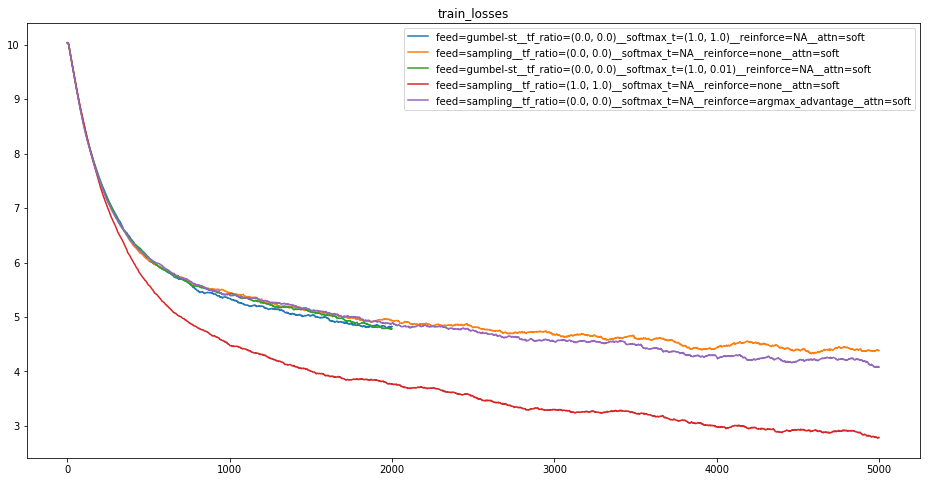

In [80]:
plt.figure(figsize=(16, 8))

name = 'train_losses'
for mode_name in mode_names:
    plt.plot(exp_running_average(data[mode_name][name]['_mean']))
#plt.ylim(0, 0.5)
plt.legend(mode_names)
plt.title(name)

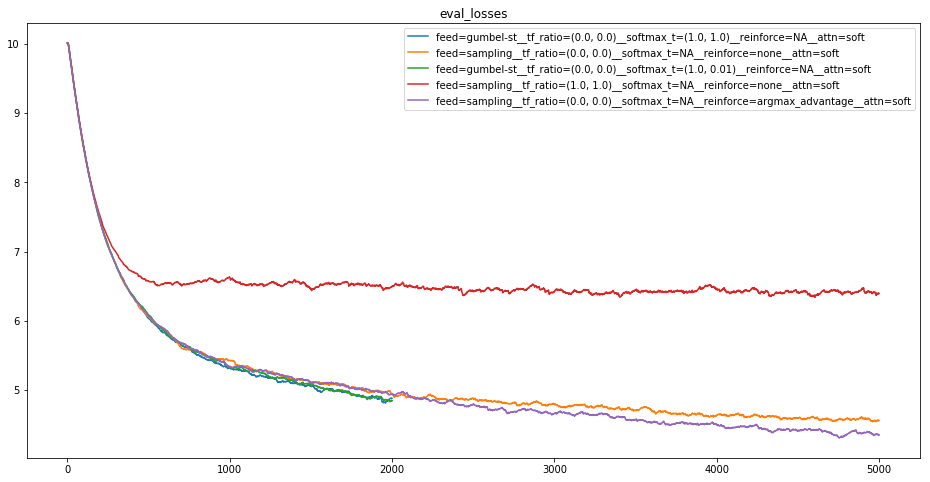

In [81]:
plt.figure(figsize=(16, 8))

name = 'eval_losses'
for mode_name in mode_names:
    plt.plot(exp_running_average(data[mode_name][name]['_mean']))
#plt.ylim(0, 0.5)
plt.legend(mode_names)
plt.title(name)

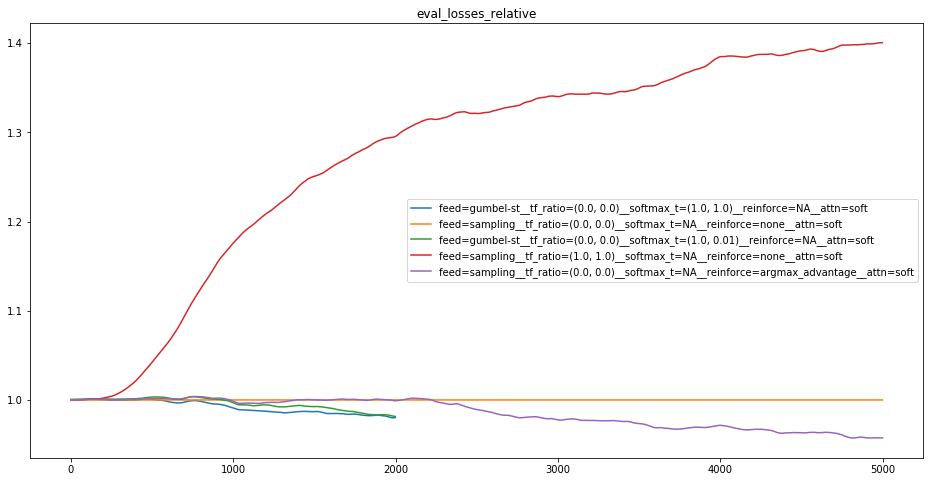

In [83]:
plt.figure(figsize=(16, 8))

name = 'eval_losses'
for mode_name in mode_names:
    plt.plot(
        exp_running_average(
            exp_running_average(data[mode_name][name]['_mean']) /\
            exp_running_average(data[baseline_mode_name][name]['_mean'][:len(data[mode_name][name]['_mean'])])
        )
    )
#plt.ylim(0, 0.5)
plt.legend(mode_names)
plt.title(name + '_relative')

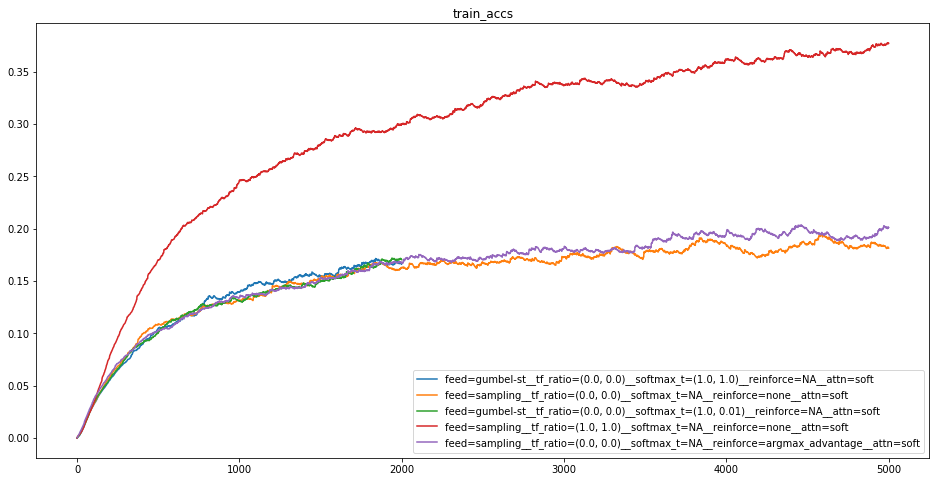

In [84]:
plt.figure(figsize=(16, 8))

name = 'train_accs'
for mode_name in mode_names:
    plt.plot(exp_running_average(data[mode_name][name]['_mean']))
#plt.ylim(0, 0.5)
plt.legend(mode_names)
plt.title(name)

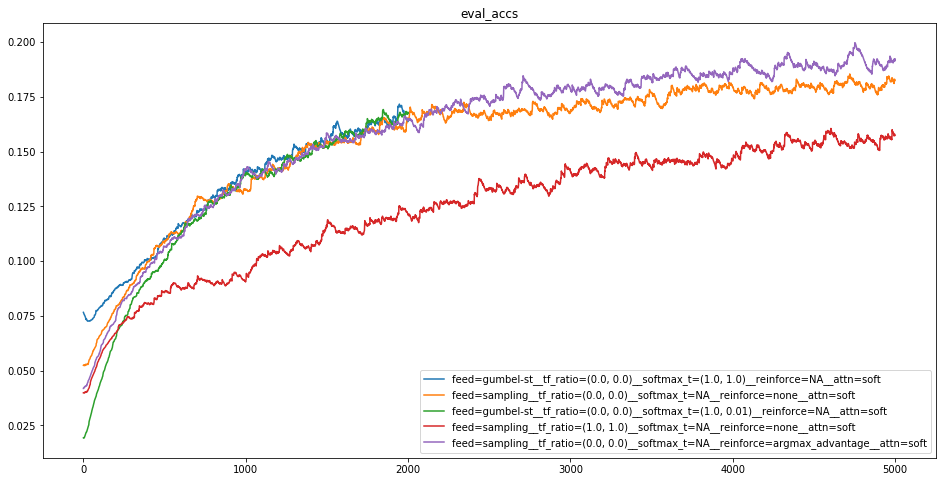

In [85]:
plt.figure(figsize=(16, 8))

name = 'eval_accs'
for mode_name in mode_names:
    plt.plot(exp_running_average(data[mode_name][name]['_mean']))
#plt.ylim(0, 0.5)
plt.legend(mode_names)
plt.title(name)

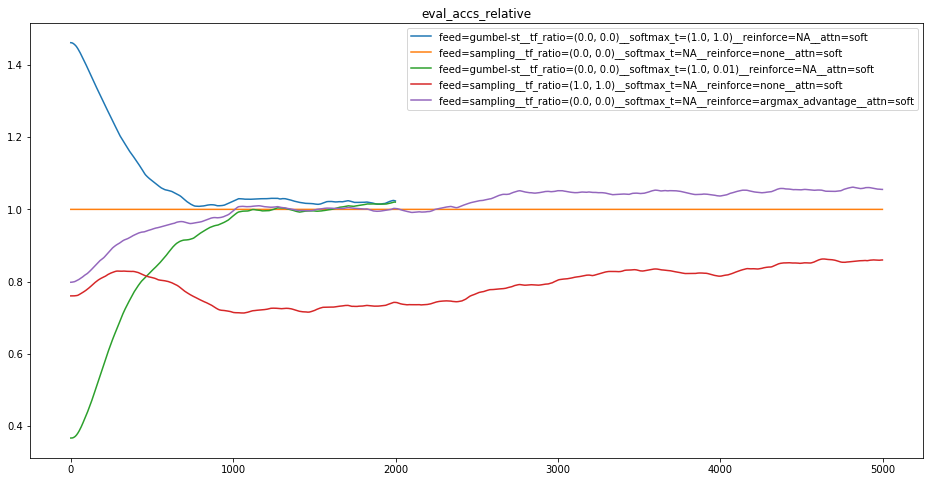

In [86]:
plt.figure(figsize=(16, 8))

name = 'eval_accs'
for mode_name in mode_names:
    plt.plot(
        exp_running_average(
            exp_running_average(data[mode_name][name]['_mean']) /\
            exp_running_average(data[baseline_mode_name][name]['_mean'][:len(data[mode_name][name]['_mean'])])
        )
    )
#plt.ylim(0, 0.5)
plt.legend(mode_names)
plt.title(name + '_relative')